In [1]:
import pandas as pd

# Load the air quality merged data
aq_df = pd.read_csv("../data/processed/merged_data_export_2.csv")


In [2]:
# Display basic info
print("Shape:", aq_df.shape)
print("Columns:", aq_df.columns.tolist())
print("\nHead:")
print(aq_df.head())

# Summary statistics
print("\nSummary statistics:")
print(aq_df.describe(include='all'))

# Check for missing values
print("\nMissing values per column:")
print(aq_df.isnull().sum())

Shape: (18748456, 9)
Columns: ['Country', 'Samplingpoint', 'Pollutant', 'Start', 'End', 'Value', 'Unit', 'AggType', 'Notation']

Head:
  Country           Samplingpoint  Pollutant                Start  \
0      NO  NO/SPO_NO0073A_38_1785         38  2019-01-01 00:00:00   
1      NO  NO/SPO_NO0073A_38_1785         38  2019-01-01 01:00:00   
2      NO  NO/SPO_NO0073A_38_1785         38  2019-01-01 02:00:00   
3      NO  NO/SPO_NO0073A_38_1785         38  2019-01-01 03:00:00   
4      NO  NO/SPO_NO0073A_38_1785         38  2019-01-01 04:00:00   

                   End   Value    Unit AggType Notation  
0  2019-01-01 01:00:00 -9900.0  ug.m-3    hour     PM10  
1  2019-01-01 02:00:00 -9900.0  ug.m-3    hour     PM10  
2  2019-01-01 03:00:00 -9900.0  ug.m-3    hour     PM10  
3  2019-01-01 04:00:00 -9900.0  ug.m-3    hour     PM10  
4  2019-01-01 05:00:00 -9900.0  ug.m-3    hour     PM10  

Summary statistics:
         Country           Samplingpoint     Pollutant                Start  \
co

In [39]:
# Add "Group" column for comparison
aq_df['Group'] = aq_df['Country'].apply(lambda x: 'NO' if x == 'NO' else 'Other')

# Grouped summary
pollutant_summary = (
    aq_df.groupby(['Group', 'Notation'])['Value']
    .agg(['count', 'mean', 'median', 'std', 'min', 'max'])
    .reset_index()
)

pollutant_summary


,Group,Notation,count,mean,median,std,min,max
0,NO,CO2,87442,41.519190,41.778036,22.270887,0.0,398.399682
1,NO,NO,903176,17.525580,12.430000,18.627769,0.0,223.000000
2,NO,NO2,757254,30.867561,23.472494,147.394513,0.0,104229.118227
3,NO,NOX as NO2,816421,8.291035,6.300000,7.797564,0.0,100.000000
4,NO,PM10,689075,31.918304,11.204758,318.116803,0.0,241777.183606
5,NO,PM2.5,705518,78.882931,41.255461,628.669960,0.0,473664.654778
6,Other,CO2,1575665,44.961200,50.100000,76.513809,-999.0,259.765000
7,Other,NO,2868948,11.174734,14.200000,81.959541,-999.0,1068.829956
8,Other,NO2,4044095,20.317907,18.800000,63.393119,-999.0,416.300000
9,Other,NOX as NO2,2005366,-0.603059,6.810724,97.325278,-999.0,1238.700000


In [ ]:
# Create hourly mean value
aq_df['hour'] = pd.to_datetime(aq_df['Start']).dt.hour

hourly_compare = (
    aq_df.groupby(['Group', 'Notation', 'hour'])['Value']
    .mean()
    .reset_index()
)

hourly_compare


In [ ]:
# Count values that are clearly invalid (e.g., -9900 is used in your dataset)
aq_df['is_invalid'] = aq_df['Value'] < -1000

invalid_stats = (
    aq_df.groupby(['Country', 'Notation'])['is_invalid']
    .mean()
    .reset_index()
    .rename(columns={'is_invalid': 'InvalidValueRate'})
    .sort_values(by='InvalidValueRate', ascending=False)
)

invalid_stats


In [ ]:
aq_df['Year'] = pd.to_datetime(aq_df['Start']).dt.year

year_coverage = (
    aq_df.groupby(['Country'])['Year']
    .agg(['min', 'max', 'nunique'])
    .reset_index()
    .rename(columns={'min': 'StartYear', 'max': 'EndYear', 'nunique': 'YearCount'})
)

year_coverage


In [ ]:
station_density = aq_df.groupby('Country')['Samplingpoint'].nunique().reset_index()
station_density.columns = ['Country', 'UniqueStations']
station_density


### cleaning Norway data

In [33]:
import numpy as np

# Define invalid or suspicious negative thresholds per pollutant if needed
# For a quick global fix, just remove obviously invalid negative values below zero for air pollutants,
# but you might want pollutant-specific logic for CO2 or NOX if valid negatives exist.

# Step 1: Define a reasonable minimum threshold for valid pollutant values
# For example, no pollutant concentration should be below 0 (or a small negative tolerance for sensor noise)
min_valid_value = 0

# Step 2: Clean the data for Norway only
mask_no = (aq_df['Country'] == 'NO')

# Remove invalid values for Norway by setting them to NaN or filtering them out
aq_df.loc[mask_no & (aq_df['Value'] < min_valid_value), 'Value'] = np.nan

# Optional: Drop rows with NaN values after cleaning (or you can impute or keep them as is)
aq_df_clean = aq_df.dropna(subset=['Value'])

# Now you can run your hourly pattern grouping and plotting on aq_df_clean
hourly_pattern = (
    aq_df_clean.groupby(['Notation', 'Country', 'hour'])['Value']
    .mean()
    .reset_index()
)


In [44]:
import numpy as np

# Step 1: Define pollutant-specific thresholds
thresholds = {
    'NO': {'min': 0, 'max': 223},
    'NOX as NO2': {'min': 0, 'max': 100},
    'CO2': {'min': 0, 'max': 1000},  # Adjust if needed
    'NO2': {'min': 0, 'max': 500},
    'PM10': {'min': 0, 'max': 500},
    'PM2.5': {'min': 0, 'max': 500}
}

# Step 2: Define known invalid placeholders
invalid_placeholders = [-888.0, -999.0]

# Step 3: Replace known invalid placeholders with NaN
aq_df['Value'] = aq_df['Value'].replace(invalid_placeholders, np.nan)

# Step 4: Apply pollutant-specific filtering for Norway and Netherlands
for country in ['NO', 'NL']:
    for pollutant, bounds in thresholds.items():
        mask = (aq_df['Country'] == country) & (aq_df['Notation'] == pollutant)
        aq_df.loc[mask & ((aq_df['Value'] < bounds['min']) | (aq_df['Value'] > bounds['max'])), 'Value'] = np.nan

# Optional: Drop NaNs for analysis (or impute if needed)
aq_df_clean = aq_df.dropna(subset=['Value'])

# Step 5: Compute hourly averages for cleaned data
hourly_pattern = (
    aq_df_clean.groupby(['Notation', 'Country', 'hour'])['Value']
    .mean()
    .reset_index()
)


## Daily analysis 

### 24h average

In [3]:
# Create a copy of aq_data
aq_df = aq_df.copy()

# Compute daily average of Value for each Pollutant per Country
daily_avg_per_country = (
    aq_df.groupby(['Country', 'Pollutant', 'Start'])['Value']
    .mean()
    .reset_index()
    .rename(columns={'Value': 'DailyAverageValue'})
)

daily_avg_per_country

,Country,Pollutant,Start,DailyAverageValue
0,AT,5,2013-01-01 00:00:00,319.393036
1,AT,5,2013-01-01 01:00:00,297.272252
2,AT,5,2013-01-01 02:00:00,158.900503
3,AT,5,2013-01-01 03:00:00,86.559707
4,AT,5,2013-01-01 04:00:00,59.949791
...,...,...,...,...
2691673,SE,6001,2023-12-31 18:00:00,4.864137
2691674,SE,6001,2023-12-31 19:00:00,5.038499
2691675,SE,6001,2023-12-31 20:00:00,4.980414
2691676,SE,6001,2023-12-31 21:00:00,4.791484


In [4]:
#summary statistics of daily average values
daily_avg_per_country.describe()

,Pollutant,DailyAverageValue
count,2.691678e+06,2.691678e+06
mean,9.863920e+02,-1.155694e+03
std,2.209423e+03,1.425966e+06
min,5.000000e+00,-1.167965e+09
25%,7.000000e+00,6.474737e+00
50%,8.000000e+00,1.695260e+01
75%,3.800000e+01,3.738338e+01
max,6.001000e+03,1.183894e+09


In [5]:
# don't think we need to get rid of outliers necessarily
#getting rid of outliers
Q1 = daily_avg_per_country['DailyAverageValue'].quantile(0.25)
Q3 = daily_avg_per_country['DailyAverageValue'].quantile(0.75)

IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

daily_avg_per_country = daily_avg_per_country[
    (daily_avg_per_country['DailyAverageValue'] >= lower_bound) &
    (daily_avg_per_country['DailyAverageValue'] <= upper_bound)
]

daily_avg_per_country

,Country,Pollutant,Start,DailyAverageValue
4,AT,5,2013-01-01 04:00:00,59.949791
5,AT,5,2013-01-01 05:00:00,52.924208
6,AT,5,2013-01-01 06:00:00,49.834083
7,AT,5,2013-01-01 07:00:00,49.908625
8,AT,5,2013-01-01 08:00:00,51.497500
...,...,...,...,...
2691673,SE,6001,2023-12-31 18:00:00,4.864137
2691674,SE,6001,2023-12-31 19:00:00,5.038499
2691675,SE,6001,2023-12-31 20:00:00,4.980414
2691676,SE,6001,2023-12-31 21:00:00,4.791484


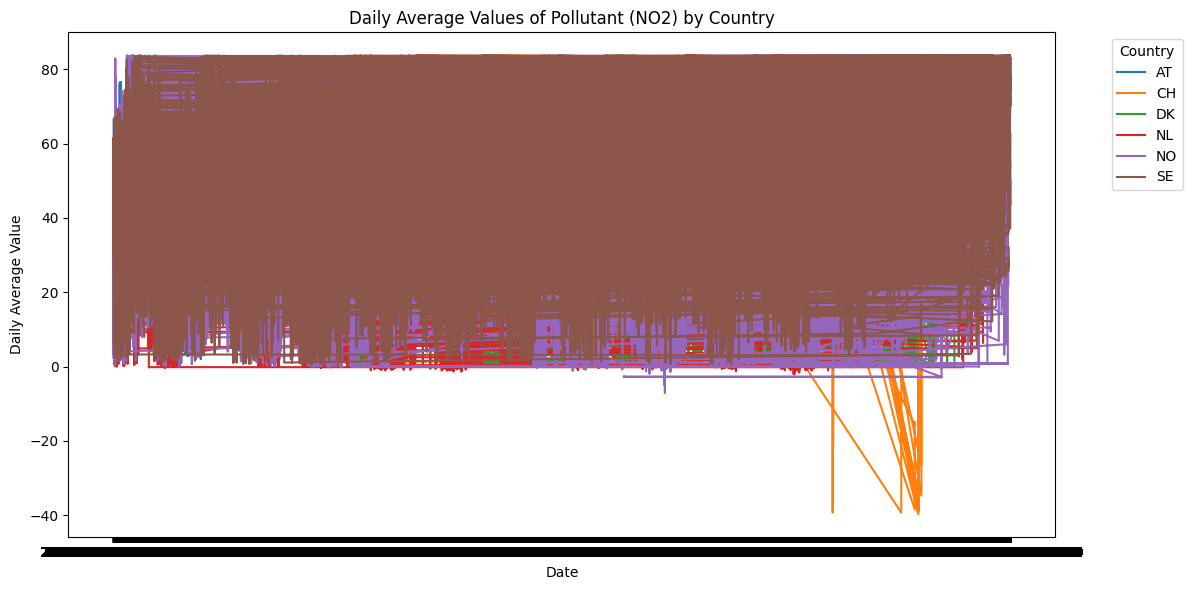

In [40]:
import matplotlib.pyplot as plt

# Filter data for a specific pollutant (e.g., NO2) for better visualization
pollutant_to_visualize = 7 # NO2
filtered_data = daily_avg_per_country[daily_avg_per_country['Pollutant'] == pollutant_to_visualize]

# Plot the data
plt.figure(figsize=(12, 6))
for country in filtered_data['Country'].unique():
    country_data = filtered_data[filtered_data['Country'] == country]
    plt.plot(country_data['Start'], country_data['DailyAverageValue'], label=country)

plt.title('Daily Average Values of Pollutant (NO2) by Country')
plt.xlabel('Date')
plt.ylabel('Daily Average Value')
plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### Day-time avg

In [7]:
aq_df

,Country,Samplingpoint,Pollutant,Start,End,Value,Unit,AggType,Notation
0,NO,NO/SPO_NO0073A_38_1785,38,2019-01-01 00:00:00,2019-01-01 01:00:00,-9900.0000,ug.m-3,hour,PM10
1,NO,NO/SPO_NO0073A_38_1785,38,2019-01-01 01:00:00,2019-01-01 02:00:00,-9900.0000,ug.m-3,hour,PM10
2,NO,NO/SPO_NO0073A_38_1785,38,2019-01-01 02:00:00,2019-01-01 03:00:00,-9900.0000,ug.m-3,hour,PM10
3,NO,NO/SPO_NO0073A_38_1785,38,2019-01-01 03:00:00,2019-01-01 04:00:00,-9900.0000,ug.m-3,hour,PM10
4,NO,NO/SPO_NO0073A_38_1785,38,2019-01-01 04:00:00,2019-01-01 05:00:00,-9900.0000,ug.m-3,hour,PM10
...,...,...,...,...,...,...,...,...,...
18748451,NL,NL/SPO-NL00003_00009_101,9,2023-12-31 19:00:00,2023-12-31 20:00:00,5.4933,ug.m-3,hour,PM2.5
18748452,NL,NL/SPO-NL00003_00009_101,9,2023-12-31 20:00:00,2023-12-31 21:00:00,4.9933,ug.m-3,hour,PM2.5
18748453,NL,NL/SPO-NL00003_00009_101,9,2023-12-31 21:00:00,2023-12-31 22:00:00,5.6933,ug.m-3,hour,PM2.5
18748454,NL,NL/SPO-NL00003_00009_101,9,2023-12-31 22:00:00,2023-12-31 23:00:00,5.3933,ug.m-3,hour,PM2.5


In [8]:
aq_df['Start'] = pd.to_datetime(aq_df['Start'])

# Filter data for day-time values (08:00:00 to 20:00:00)
day_time_data = aq_df[
    (aq_df['Start'].dt.time >= pd.to_datetime('08:00:00').time()) &
    (aq_df['Start'].dt.time <= pd.to_datetime('20:00:00').time())
]

# Compute daily mean for each pollutant value for each country
daily_daytime_avg_per_country = (
    day_time_data.groupby(['Country', 'Pollutant', day_time_data['Start'].dt.date])['Value']
    .mean()
    .reset_index()
    .rename(columns={'Start': 'Date', 'Value': 'DailyDaytimeAverageValue'})
)

daily_daytime_avg_per_country

,Country,Pollutant,Date,DailyDaytimeAverageValue
0,AT,5,2013-01-01,52.110413
1,AT,5,2013-01-02,25.221235
2,AT,5,2013-01-03,9.707832
3,AT,5,2013-01-04,9.635445
4,AT,5,2013-01-05,3.943111
...,...,...,...,...
112157,SE,6001,2023-12-27,2.160642
112158,SE,6001,2023-12-28,3.408451
112159,SE,6001,2023-12-29,4.994276
112160,SE,6001,2023-12-30,4.303493


In [9]:
#summary statistics
summary_stats = daily_daytime_avg_per_country['DailyDaytimeAverageValue'].describe()
print(summary_stats)

#remove outliers
Q1 = daily_daytime_avg_per_country['DailyDaytimeAverageValue'].quantile(0.25)
Q3 = daily_daytime_avg_per_country['DailyDaytimeAverageValue'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

daily_daytime_avg_per_country = daily_daytime_avg_per_country[
    (daily_daytime_avg_per_country['DailyDaytimeAverageValue'] >= lower_bound) &
    (daily_daytime_avg_per_country['DailyDaytimeAverageValue'] <= upper_bound)
]

daily_daytime_avg_per_country

count    1.121620e+05
mean    -1.069675e+03
std      4.204779e+05
min     -1.399059e+08
25%      7.354089e+00
50%      1.966524e+01
75%      4.187901e+01
max      1.245011e+07
Name: DailyDaytimeAverageValue, dtype: float64


,Country,Pollutant,Date,DailyDaytimeAverageValue
0,AT,5,2013-01-01,52.110413
1,AT,5,2013-01-02,25.221235
2,AT,5,2013-01-03,9.707832
3,AT,5,2013-01-04,9.635445
4,AT,5,2013-01-05,3.943111
...,...,...,...,...
112157,SE,6001,2023-12-27,2.160642
112158,SE,6001,2023-12-28,3.408451
112159,SE,6001,2023-12-29,4.994276
112160,SE,6001,2023-12-30,4.303493


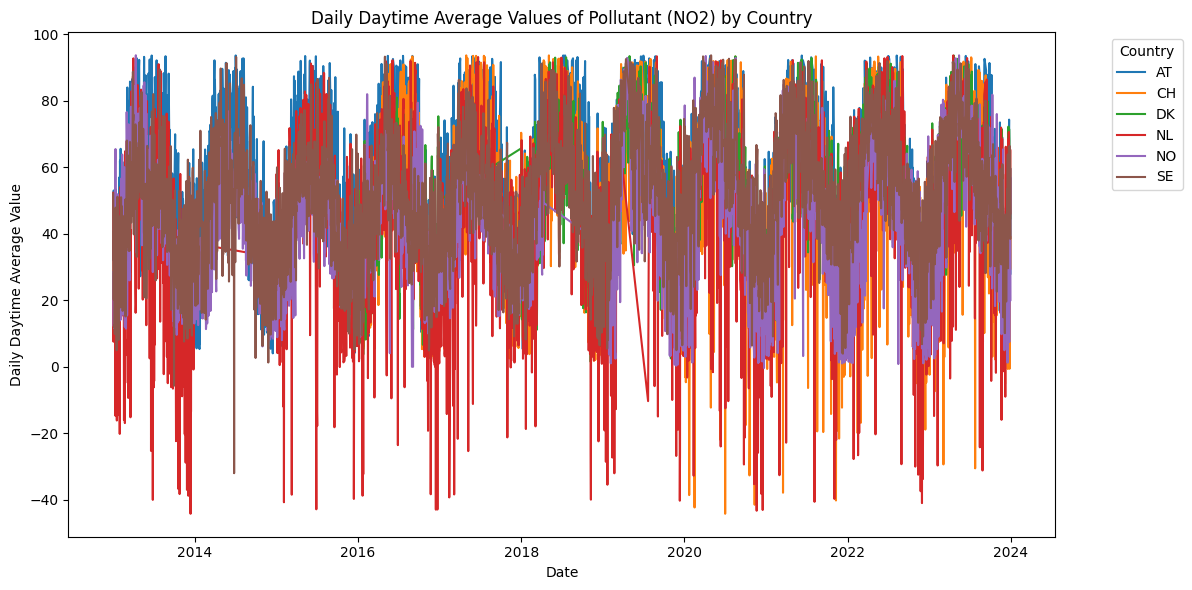

In [10]:
import matplotlib.pyplot as plt

# Filter data for a specific pollutant (e.g., NO2) for better visualization
pollutant_to_visualize = 7  # NO2
filtered_data = daily_daytime_avg_per_country[daily_daytime_avg_per_country['Pollutant'] == pollutant_to_visualize]

# Plot the data
plt.figure(figsize=(12, 6))
for country in filtered_data['Country'].unique():
    country_data = filtered_data[filtered_data['Country'] == country]
    plt.plot(country_data['Date'], country_data['DailyDaytimeAverageValue'], label=country)

plt.title('Daily Daytime Average Values of Pollutant (NO2) by Country')
plt.xlabel('Date')
plt.ylabel('Daily Daytime Average Value')
plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

/var/folders/c8/hcty8r1j2xj189pdz208fpnr0000gn/T/ipykernel_12385/2195508913.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_daytime_avg_per_country['DayOfWeek'] = pd.to_datetime(daily_daytime_avg_per_country['Date']).dt.dayofweek
/var/folders/c8/hcty8r1j2xj189pdz208fpnr0000gn/T/ipykernel_12385/2195508913.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_daytime_avg_per_country['IsWeekend'] = daily_daytime_avg_per_country['DayOfWeek'].isin([5, 6])  # Saturday and Sunday


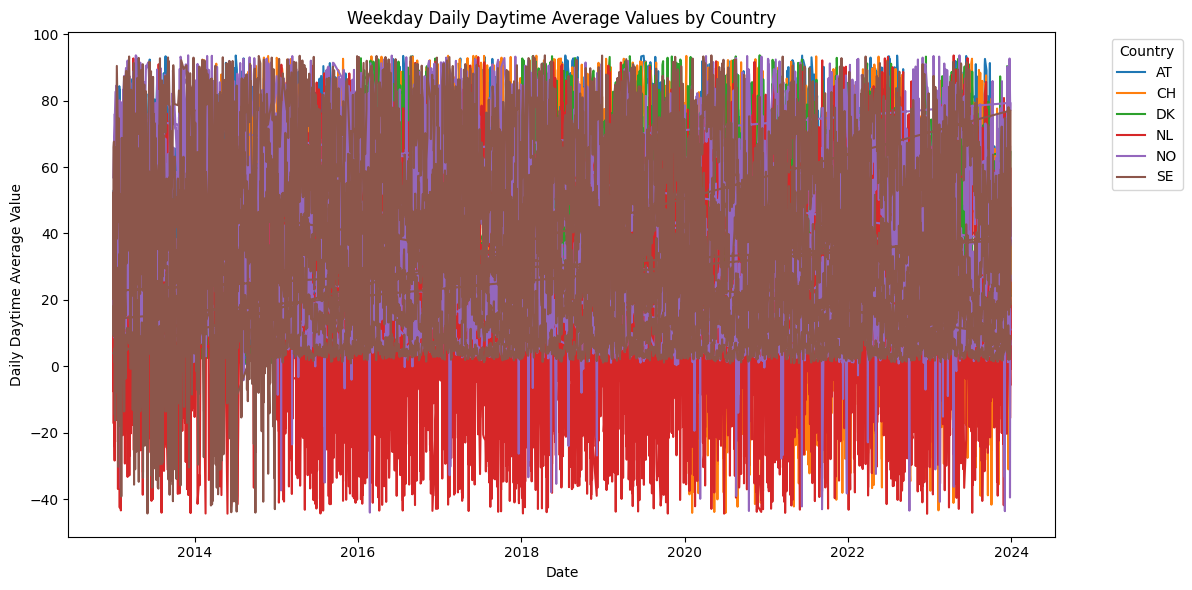

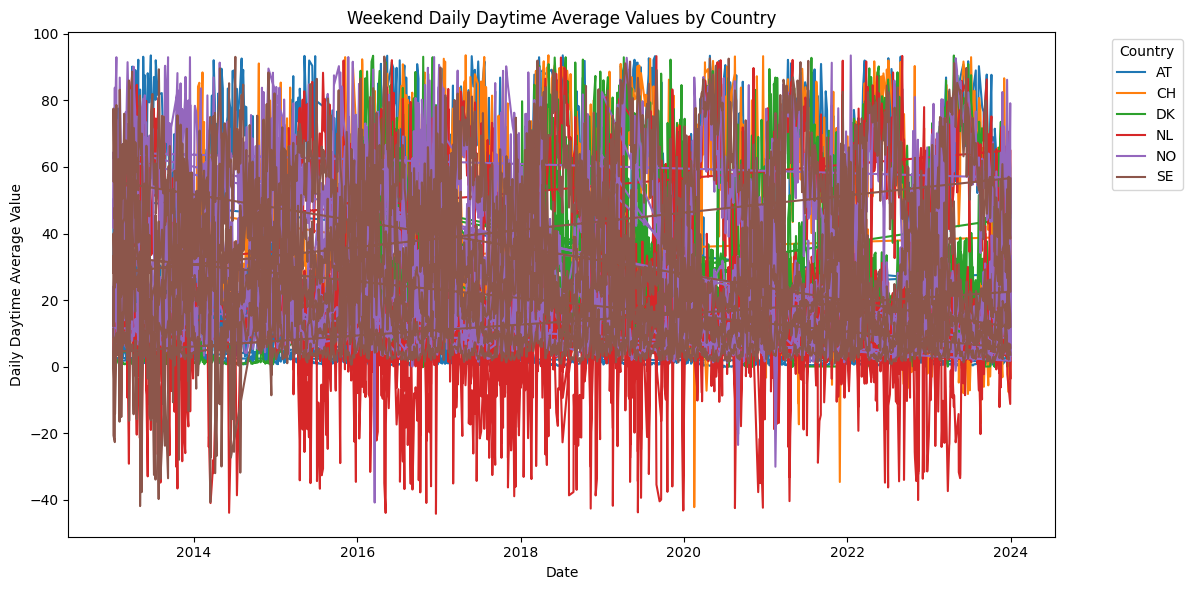

In [11]:
# Add a column to indicate whether the day is a weekday or weekend
daily_daytime_avg_per_country['DayOfWeek'] = pd.to_datetime(daily_daytime_avg_per_country['Date']).dt.dayofweek
daily_daytime_avg_per_country['IsWeekend'] = daily_daytime_avg_per_country['DayOfWeek'].isin([5, 6])  # Saturday and Sunday

# Separate data for weekdays and weekends
weekday_data = daily_daytime_avg_per_country[~daily_daytime_avg_per_country['IsWeekend']]
weekend_data = daily_daytime_avg_per_country[daily_daytime_avg_per_country['IsWeekend']]

# Plot weekday data
plt.figure(figsize=(12, 6))
for country in weekday_data['Country'].unique():
    country_data = weekday_data[weekday_data['Country'] == country]
    plt.plot(country_data['Date'], country_data['DailyDaytimeAverageValue'], label=country)

plt.title('Weekday Daily Daytime Average Values by Country')
plt.xlabel('Date')
plt.ylabel('Daily Daytime Average Value')
plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Plot weekend data
plt.figure(figsize=(12, 6))
for country in weekend_data['Country'].unique():
    country_data = weekend_data[weekend_data['Country'] == country]
    plt.plot(country_data['Date'], country_data['DailyDaytimeAverageValue'], label=country)

plt.title('Weekend Daily Daytime Average Values by Country')
plt.xlabel('Date')
plt.ylabel('Daily Daytime Average Value')
plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### Hourly air pollutant patterns (aggregated for all countries)

In [13]:
aq_df

,Country,Samplingpoint,Pollutant,Start,End,Value,Unit,AggType,Notation
0,NO,NO/SPO_NO0073A_38_1785,38,2019-01-01 00:00:00,2019-01-01 01:00:00,-9900.0000,ug.m-3,hour,PM10
1,NO,NO/SPO_NO0073A_38_1785,38,2019-01-01 01:00:00,2019-01-01 02:00:00,-9900.0000,ug.m-3,hour,PM10
2,NO,NO/SPO_NO0073A_38_1785,38,2019-01-01 02:00:00,2019-01-01 03:00:00,-9900.0000,ug.m-3,hour,PM10
3,NO,NO/SPO_NO0073A_38_1785,38,2019-01-01 03:00:00,2019-01-01 04:00:00,-9900.0000,ug.m-3,hour,PM10
4,NO,NO/SPO_NO0073A_38_1785,38,2019-01-01 04:00:00,2019-01-01 05:00:00,-9900.0000,ug.m-3,hour,PM10
...,...,...,...,...,...,...,...,...,...
18748451,NL,NL/SPO-NL00003_00009_101,9,2023-12-31 19:00:00,2023-12-31 20:00:00,5.4933,ug.m-3,hour,PM2.5
18748452,NL,NL/SPO-NL00003_00009_101,9,2023-12-31 20:00:00,2023-12-31 21:00:00,4.9933,ug.m-3,hour,PM2.5
18748453,NL,NL/SPO-NL00003_00009_101,9,2023-12-31 21:00:00,2023-12-31 22:00:00,5.6933,ug.m-3,hour,PM2.5
18748454,NL,NL/SPO-NL00003_00009_101,9,2023-12-31 22:00:00,2023-12-31 23:00:00,5.3933,ug.m-3,hour,PM2.5


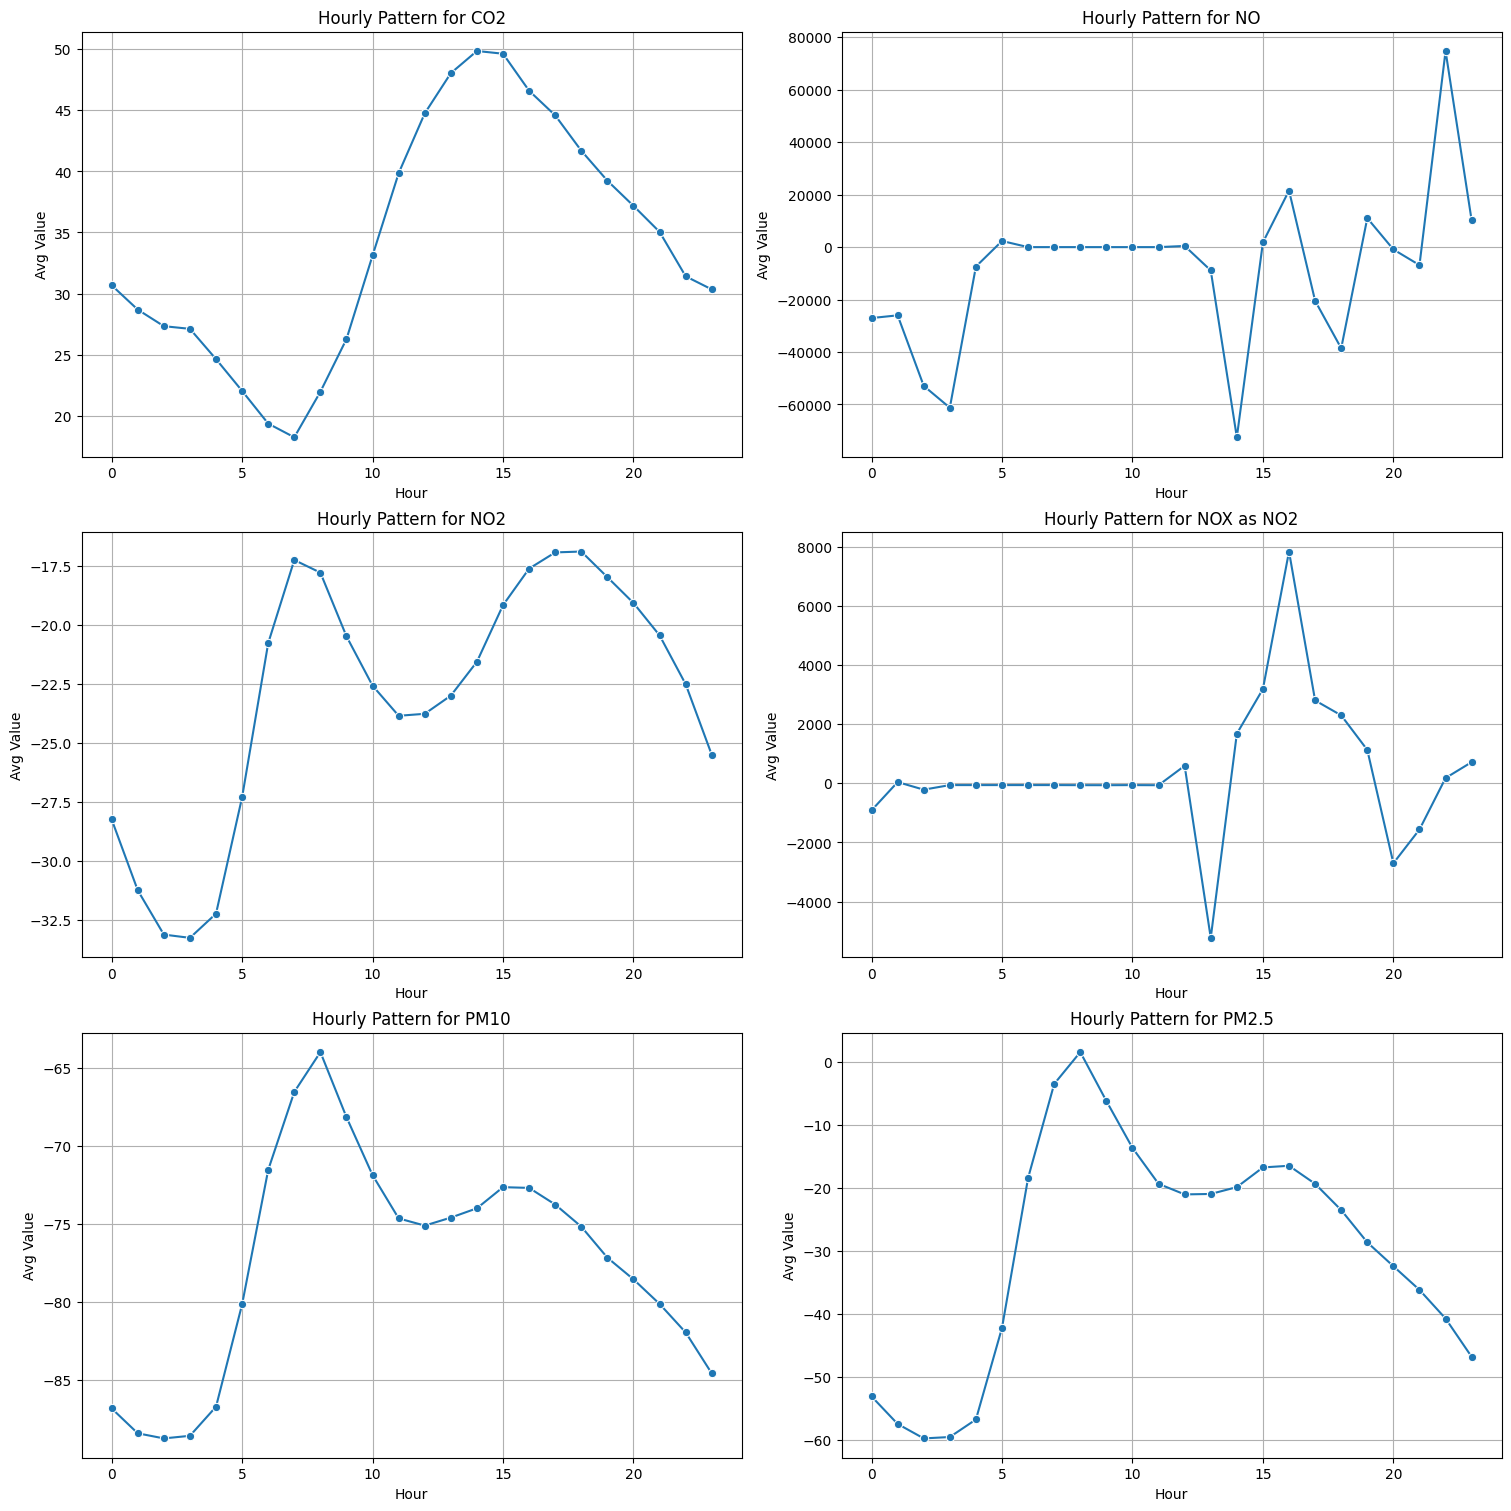

In [18]:
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

# Ensure datetime format and extract hour column
aq_df['Start'] = pd.to_datetime(aq_df['Start'])
aq_df['hour'] = aq_df['Start'].dt.hour

# Compute average value by hour and pollutant notation
pollutant_hourly_pattern = (
    aq_df.groupby(['hour', 'Notation'])['Value']
    .mean()
    .reset_index()
)
unique_pollutants = pollutant_hourly_pattern['Notation'].unique()

# Define the number of rows and columns for the grid
ncols = 2
nrows = (len(unique_pollutants) + ncols - 1) // ncols  # Calculate rows needed

# Create subplots
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 5 * nrows), constrained_layout=True)

# Flatten axes for easy iteration
axes = axes.flatten()

# Plot each pollutant in a separate subplot
for ax, pollutant in zip(axes, unique_pollutants):
    data = pollutant_hourly_pattern[pollutant_hourly_pattern['Notation'] == pollutant]
    sns.lineplot(data=data, x='hour', y='Value', ax=ax, marker='o')
    ax.set_title(f"Hourly Pattern for {pollutant}")
    ax.set_xlabel("Hour")
    ax.set_ylabel("Avg Value")
    ax.grid(True)

# Hide any unused subplots
for ax in axes[len(unique_pollutants):]:
    ax.set_visible(False)

plt.show()

### Hourly air pollutant patterns (country breakdown)

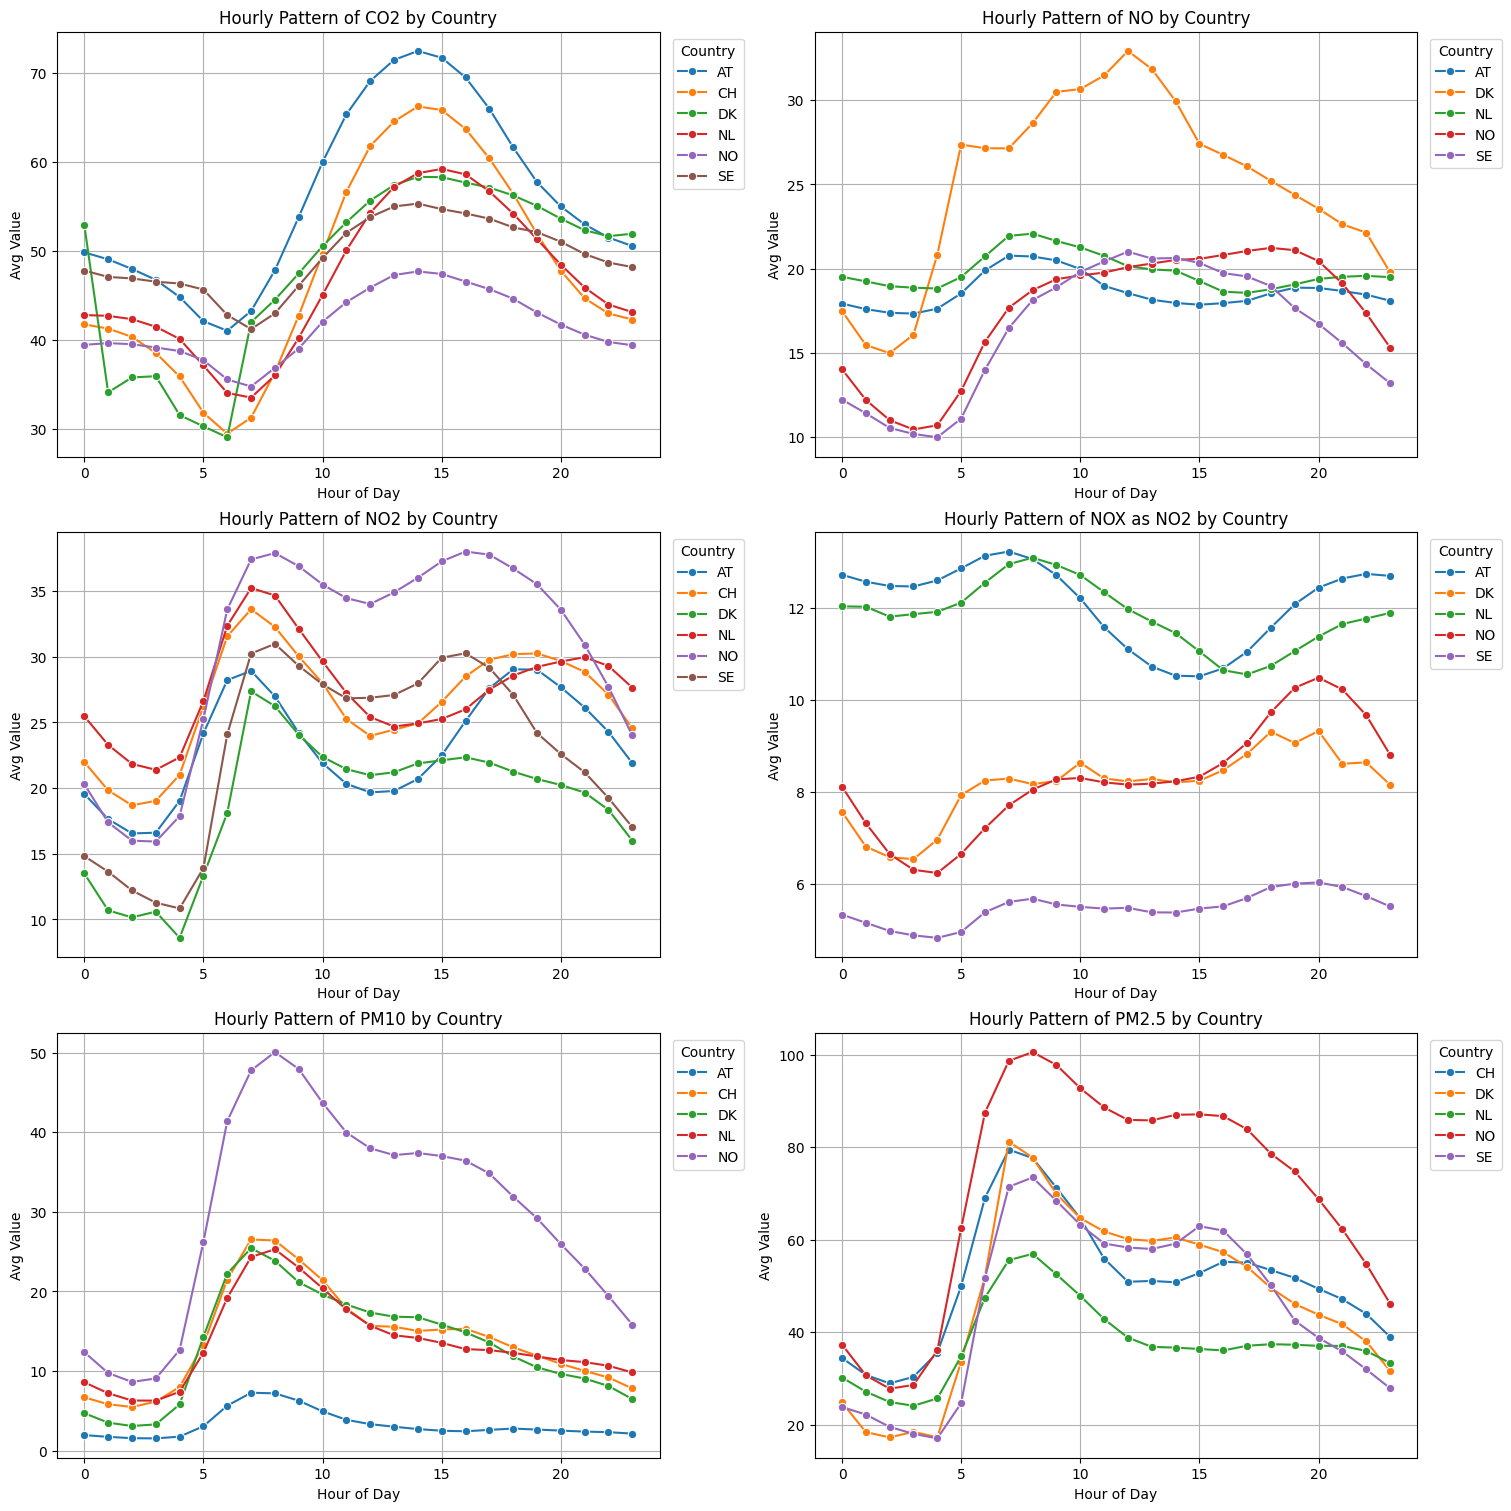

In [46]:
# Group and compute average value per hour per pollutant per country --> inconsistent colors across countries, NO data needs cleaning
hourly_pattern = (
    aq_df_clean.groupby(['Notation', 'Country', 'hour'])['Value']
    .mean()
    .reset_index()
)

# Unique pollutants (Notation column)
unique_pollutants = hourly_pattern['Notation'].unique()

# Define the number of rows and columns for the grid
ncols = 2
nrows = (len(unique_pollutants) + ncols - 1) // ncols  # Calculate rows needed

# Create subplots
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 5 * nrows), constrained_layout=True)

# Flatten axes for easy iteration
axes = axes.flatten()

# Plot each pollutant, with a line per country
for ax, pollutant in zip(axes, unique_pollutants):
    data = hourly_pattern[hourly_pattern['Notation'] == pollutant]
    sns.lineplot(data=data, x='hour', y='Value', hue='Country', marker='o', ax=ax)
    ax.set_title(f"Hourly Pattern of {pollutant} by Country")
    ax.set_xlabel("Hour of Day")
    ax.set_ylabel("Avg Value")
    ax.grid(True)
    ax.legend(title='Country', bbox_to_anchor=(1.01, 1), loc='upper left')

# Hide any unused subplots
for ax in axes[len(unique_pollutants):]:
    ax.set_visible(False)

plt.show()

In [42]:
# Add "Group" column for comparison
aq_df['Group'] = aq_df['Country'].apply(lambda x: 'NL' if x == 'NL' else 'Other')

# Grouped summary
pollutant_summary = (
    aq_df.groupby(['Group', 'Notation'])['Value']
    .agg(['count', 'mean', 'median', 'std', 'min', 'max'])
    .reset_index()
)

pollutant_summary


,Group,Notation,count,mean,median,std,min,max
0,NL,CO2,262944,23.420553,46.300000,145.850260,-888.0,215.900000
1,NL,NO,631080,-8.919925,16.900000,159.424686,-888.0,636.100000
2,NL,NO2,867768,13.690029,22.200000,113.238423,-888.0,416.300000
3,NL,NOX as NO2,438240,-22.584442,8.600000,172.582444,-888.0,945.600000
4,NL,PM10,859008,-0.621349,3.400000,112.881773,-888.0,794.500000
5,NL,PM2.5,482064,25.110467,23.913300,116.289561,-888.0,1323.740000
6,Other,CO2,1400163,48.791473,50.179000,50.232010,-999.0,398.399682
7,Other,NO,3141044,17.038157,13.020000,32.013425,-999.0,1068.829956
8,Other,NO2,3933581,23.810965,18.719976,74.058266,-999.0,104229.118227
9,Other,NOX as NO2,2383547,6.484884,6.300000,49.009647,-999.0,1238.700000


### Peak-traffic hour windows

In [41]:
# Filter data for the specified time ranges
peak_traffic_data = aq_df[
    ((aq_df['Start'].dt.time >= pd.to_datetime('06:00:00').time()) & 
     (aq_df['Start'].dt.time <= pd.to_datetime('10:00:00').time())) |
    ((aq_df['Start'].dt.time >= pd.to_datetime('16:00:00').time()) & 
     (aq_df['Start'].dt.time <= pd.to_datetime('20:00:00').time()))
]

# Compute daily mean for each pollutant value for each country
daily_peak_traffic_avg_per_country = (
    peak_traffic_data.groupby(['Country', 'Pollutant', peak_traffic_data['Start'].dt.date])['Value']
    .mean()
    .reset_index()
    .rename(columns={'Start': 'Date', 'Value': 'DailyPeakTrafficAverageValue'})
)

daily_peak_traffic_avg_per_country

,Country,Pollutant,Date,DailyPeakTrafficAverageValue
0,AT,5,2013-01-01,51.586312
1,AT,5,2013-01-02,31.677111
2,AT,5,2013-01-03,12.501949
3,AT,5,2013-01-04,8.393159
4,AT,5,2013-01-05,3.950906
...,...,...,...,...
112158,SE,6001,2023-12-27,2.064120
112159,SE,6001,2023-12-28,3.301898
112160,SE,6001,2023-12-29,4.235641
112161,SE,6001,2023-12-30,4.010001


In [ ]:
# Generate summary statistics
summary_stats = daily_peak_traffic_avg_per_country['DailyPeakTrafficAverageValue'].describe()
print(summary_stats)

# Remove outliers using the IQR method
Q1 = daily_peak_traffic_avg_per_country['DailyPeakTrafficAverageValue'].quantile(0.25)
Q3 = daily_peak_traffic_avg_per_country['DailyPeakTrafficAverageValue'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

daily_peak_traffic_avg_per_country = daily_peak_traffic_avg_per_country[
    (daily_peak_traffic_avg_per_country['DailyPeakTrafficAverageValue'] >= lower_bound) &
    (daily_peak_traffic_avg_per_country['DailyPeakTrafficAverageValue'] <= upper_bound)
]

daily_peak_traffic_avg_per_country

count    9.207800e+04
mean    -3.375996e+02
std      1.958049e+05
min     -5.595444e+07
25%      7.274157e+00
50%      1.918641e+01
75%      4.003498e+01
max      1.552745e+07
Name: DailyPeakTrafficAverageValue, dtype: float64


,Country,Pollutant,Date,DailyPeakTrafficAverageValue
0,AT,5,2013-01-01,51.586312
1,AT,5,2013-01-02,31.677111
2,AT,5,2013-01-03,12.501949
3,AT,5,2013-01-04,8.393159
4,AT,5,2013-01-05,3.950906
...,...,...,...,...
92073,NO,6001,2023-12-27,22.545110
92074,NO,6001,2023-12-28,9.120578
92075,NO,6001,2023-12-29,7.111636
92076,NO,6001,2023-12-30,9.878856


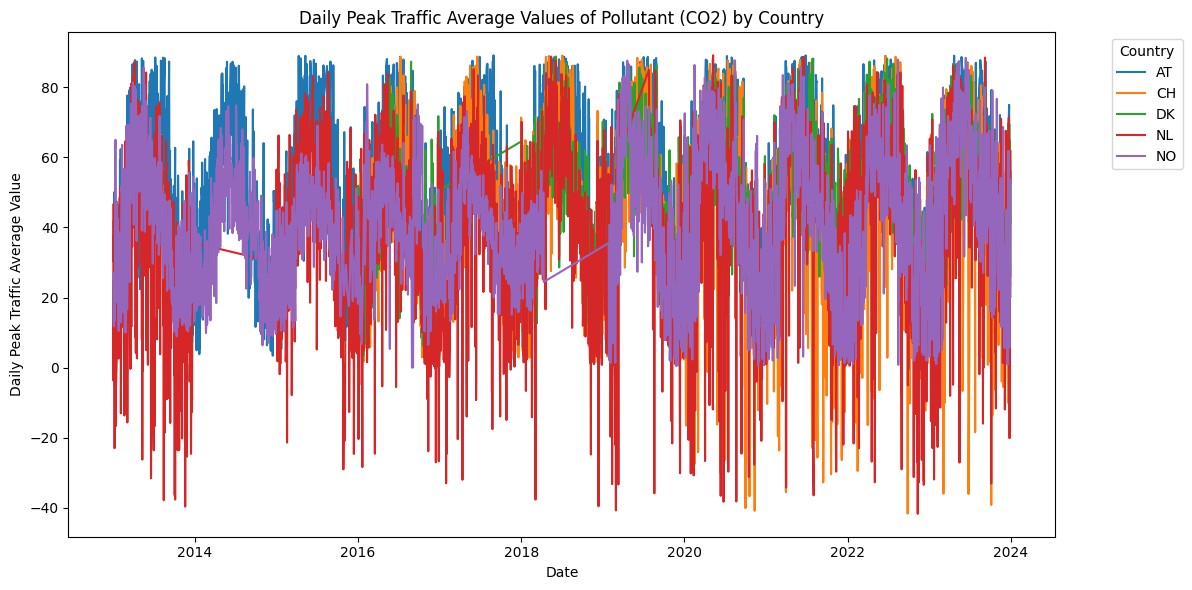

In [ ]:
# Filter data for a specific pollutant (e.g., NO2) for better visualization
pollutant_to_visualize = 7 # CO2
filtered_data = daily_peak_traffic_avg_per_country[daily_peak_traffic_avg_per_country['Pollutant'] == pollutant_to_visualize]

# Plot the data
plt.figure(figsize=(12, 6))
for country in filtered_data['Country'].unique():
    country_data = filtered_data[filtered_data['Country'] == country]
    plt.plot(country_data['Date'], country_data['DailyPeakTrafficAverageValue'], label=country)

plt.title('Daily Peak Traffic Average Values of Pollutant (CO2) by Country')
plt.xlabel('Date')
plt.ylabel('Daily Peak Traffic Average Value')
plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Per year-analysis

In [ ]:
# Load the annual averages data
aq_annual_averages = pd.read_csv("../data/processed/AQ_annual_averages.csv")

# Display basic info
print("Shape:", aq_annual_averages.shape)
print("Columns:", aq_annual_averages.columns.tolist())
print("\nHead:")
print(aq_annual_averages.head())

# Investigate unique years, countries, and pollutants
years = aq_annual_averages['Year'].unique()
countries = aq_annual_averages['Country'].unique()
pollutants = aq_annual_averages['Pollutant'].unique()

print(f"\nYears in data: {years}")
print(f"Number of countries: {len(countries)}")
print(f"Number of pollutants: {len(pollutants)}")

# For each year, count unique countries and pollutants with annual averages
summary = aq_annual_averages.groupby('Year').agg(
    num_countries=('Country', 'nunique'),
    num_pollutants=('Pollutant', 'nunique')
).reset_index()

print("\nAnnual coverage summary:")
print(summary)

## Quarterly analysis (pull )

/var/folders/c8/hcty8r1j2xj189pdz208fpnr0000gn/T/ipykernel_12385/1700334789.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  func(*plot_args, **plot_kwargs)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  func(*plot_args, **plot_kwargs)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  func(*plot_args, **plot_kwargs)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/seaborn/axisgrid.py:854: FutureWar

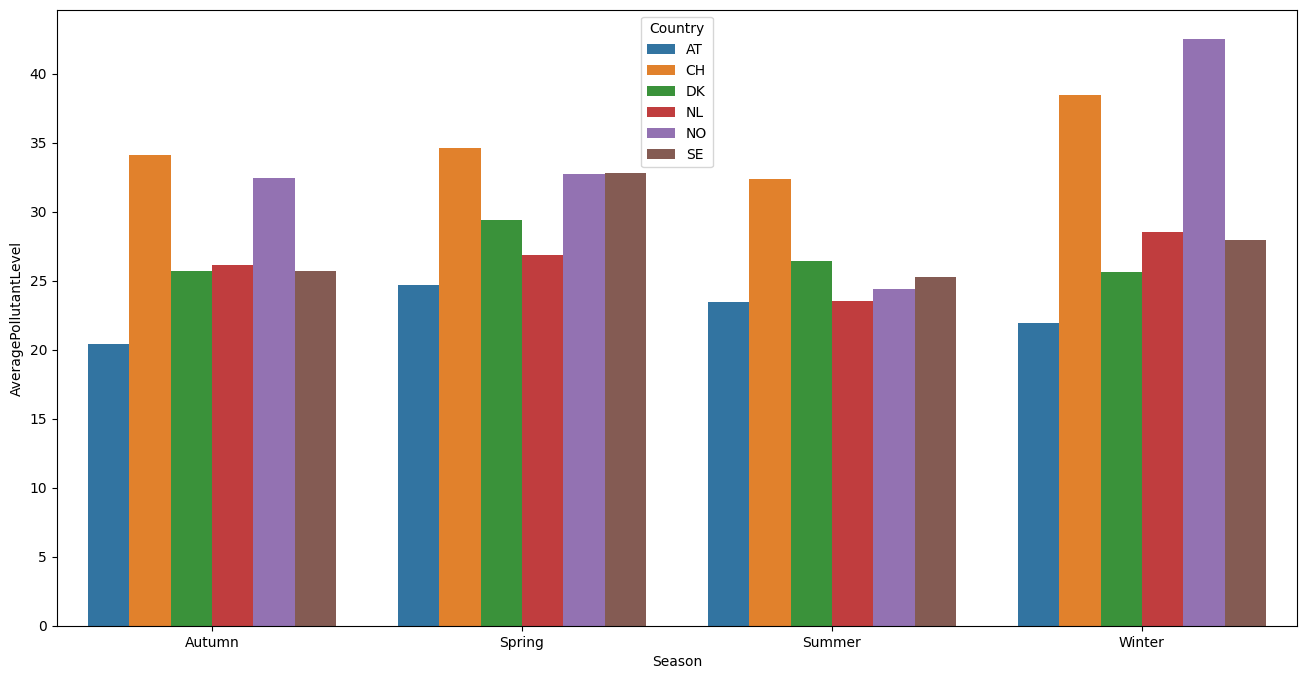

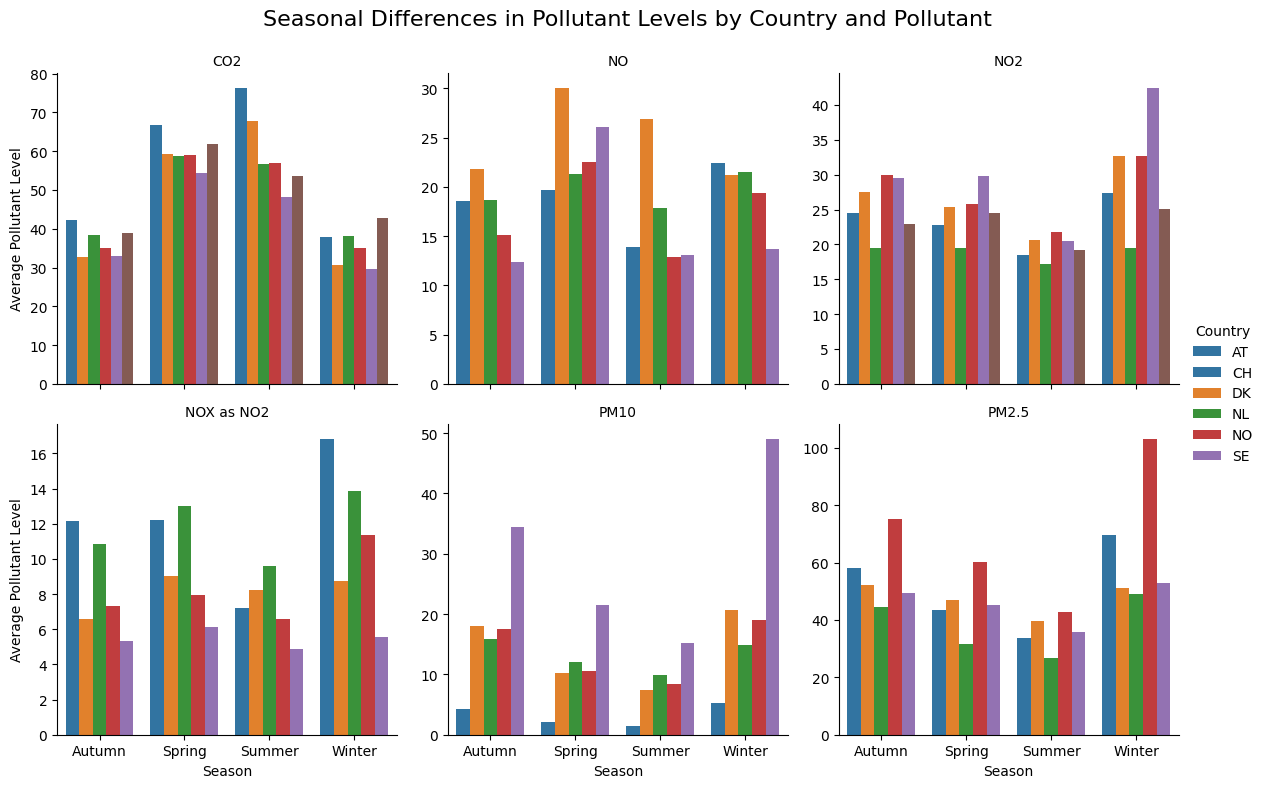

In [49]:
import seaborn as sns

import matplotlib.pyplot as plt

# Create a grouped bar plot for seasonal pollutant levels by country
plt.figure(figsize=(16, 8))
sns.barplot(
    data=seasonal_pollutant_levels,
    x='Season',
    y='AveragePollutantLevel',
    hue='Country',
    ci=None,
    palette='tab10'
)

# Add pollutant details as a facet grid
g = sns.FacetGrid(seasonal_pollutant_levels, col="Notation", col_wrap=3, height=4, sharey=False)
g.map_dataframe(
    sns.barplot,
    x="Season",
    y="AveragePollutantLevel",
    hue="Country",
    ci=None,
    palette="tab10"
)
g.add_legend(title="Country")

# Set titles and labels
g.set_titles("{col_name}")
g.set_axis_labels("Season", "Average Pollutant Level")
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Seasonal Differences in Pollutant Levels by Country and Pollutant", fontsize=16)

plt.show()

### Country level pollutant correlation

In [50]:
# Pivot the data to create a wide-format dataframe with pollutants as columns
correlation_data = aq_df_clean.pivot_table(
    index=['Start', 'Country'], 
    columns='Notation', 
    values='Value'
).reset_index()

# Iterate through each country and compute the correlation matrix
correlation_matrices = {}
for country in correlation_data['Country'].unique():
    country_data = correlation_data[correlation_data['Country'] == country].drop(columns=['Start', 'Country'])
    correlation_matrices[country] = country_data.corr()

# Display the correlation matrix for each country
for country, corr_matrix in correlation_matrices.items():
    print(f"Correlation Matrix for {country}:")
    print(corr_matrix)
    print("\n")

Correlation Matrix for AT:
Notation         CO2        NO       NO2  NOX as NO2      PM10  PM2.5
Notation                                                             
CO2         1.000000 -0.269027 -0.421096   -0.420739 -0.397259    NaN
NO         -0.269027  1.000000  0.586356    0.932071  0.352853    NaN
NO2        -0.421096  0.586356  1.000000    0.515315  0.516634    NaN
NOX as NO2 -0.420739  0.932071  0.515315    1.000000  0.335631    NaN
PM10       -0.397259  0.352853  0.516634    0.335631  1.000000    NaN
PM2.5            NaN       NaN       NaN         NaN       NaN    NaN


Correlation Matrix for DK:
Notation         CO2        NO       NO2  NOX as NO2      PM10     PM2.5
Notation                                                                
CO2         1.000000  0.071900 -0.199688   -0.022378 -0.322607 -0.255290
NO          0.071900  1.000000  0.405458    0.344142  0.369086  0.393838
NO2        -0.199688  0.405458  1.000000    0.230521  0.751221  0.918534
NOX as NO2 -0.02237

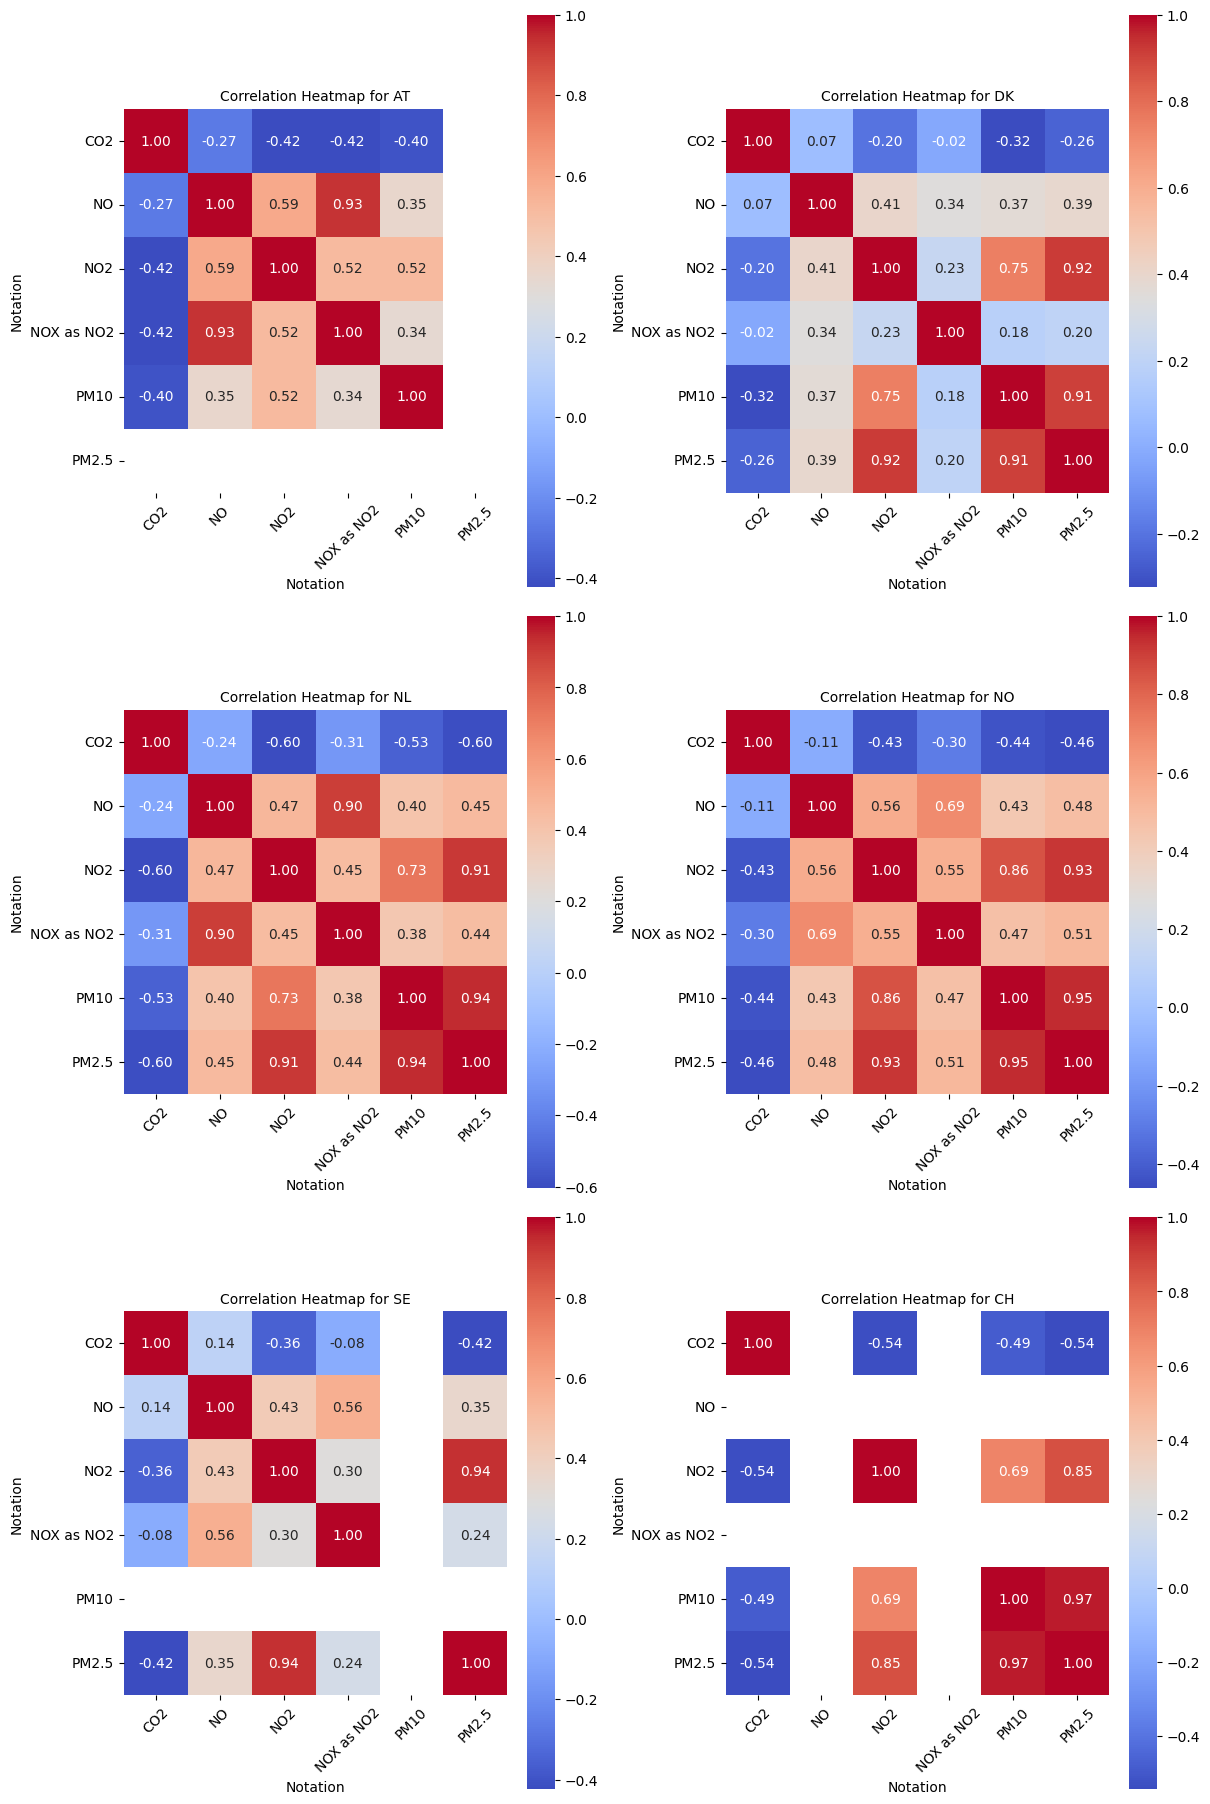

In [53]:
import seaborn as sns

import matplotlib.pyplot as plt

# Define the number of columns for the grid
ncols = 2
nrows = (len(correlation_matrices) + ncols - 1) // ncols  # Calculate rows needed

# Create subplots
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 6 * nrows), constrained_layout=True)

# Flatten axes for easy iteration
axes = axes.flatten()

# Iterate through each country's correlation matrix and plot a heatmap
for ax, (country, corr_matrix) in zip(axes, correlation_matrices.items()):
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, square=True, ax=ax)
    ax.set_title(f"Correlation Heatmap for {country}", fontsize=10)
    ax.tick_params(axis='x', rotation=45)
    ax.tick_params(axis='y', rotation=0)

# Hide any unused subplots
for ax in axes[len(correlation_matrices):]:
    ax.set_visible(False)

plt.show()